# On-the-Fly Code Generation for Image Processing

Imagine a program with the sole purpose of finding all occurrences of a single predefined character in an input text. Implementing an efficient version of that program hardly requires any expertise, but it also ain't particularly useful, is it? It would have been better if it could match any arbitrary character. While at it, why not make it a sequence of characters? Maybe with some wild cards inbetween for good measure, perhaps even with rules on what every occurrence should start and end with. Before we realize it, we end up with the requirements of a full blown regular expression matcher at our hands. Beyond a certain point, the algorithm remains, at its core, unchanged -- while the current text character matches the current regular expression criteria, advance both and see how that goes. But that added functionality does not come without a cost. The machinery needed to implement it, even if designed by the most experienced computer scientist, can't possibly run as quickly as a simple character matcher, even if, at the end, its purpose turns out to be exactly this. Luckily, really being so experienced often means there's always something up one's sleeve. 

On-the-fly code generation is an optimization technique which can be used to greatly reduce the execution time of an algorithm on a given input instance. In an essence, the trick is to dynamically create a brand new algorithm which is, in a way, hard-coded to the input, and execute this algorithm instead. Of course, this does not come without an overhead. But when the goal is to apply that exact same regular expression on the entire Wikipedia corpus, this overhead might turn out to be rather insignificant.

Similarly enough, when the goal is to apply that same image processing operation on an entire video stream, on-the-fly code generation might come handy. I hope that rapid change of context didn't bother you too much. I thought giving two examples in one go is neat. But if that pesky context change bothers you too much, then we're on the same page! While code generation usually involves low level (assembly / intermediate language/ whatever) code, Cogpyt attempts to make this practice accessible to any programmer.

Our main goal in this notebook will be to showcase Cogpyt by optimizing a naive 2D convolution algorithm with on-the-fly code generation. Neither should you be bothered if you are not familiar with that particular algorithm, nor if you aren't at all hyped about image processing or computer vision. In fact, we won't really go into too much detail about the algorithm itself, as I believe the optimization procedure itself is simple enough to be understandable, without further context, by any programmer. After all, there are already way too many resources on image convolution out there. Perhaps Stanford's CS231n course, in particular [CS231n Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/convolutional-networks/), is a good starting point.

Essentially, an image convolution operation consists of dragging a filter, or kernel, across an image. The result is highly dependent on the particular kernel and finding *useful* kernels is in fact what Convolutional Neural Networks 
really do when being *trained*. Below is an example of such an operation I found on Wikimedia.


[![Animation of 2d convolution by Wikimedia](https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif)](https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif)

In this example, we are going to apply what is formally known as a Sobel operator to an image. The concrete version of this operator we are using is a symmetric kernel containing negative numbers on the left side and equally normed positive ones on the right side. It effectively detects horizontal brightness transitions, which correspond to vertical edges. Without further ado, let's see the input image and kernel, as well as the naive 2D convolution implementation.

In [1]:
# Dependencies: numpy, pillow, numba, cogpyt, _convolution_functions.py

# implementation of 2d convolution on flat arrays
from _convolution_functions import get_lena, get_sobel, convolve_naive, convolve_cogpyt
from _convolution_functions import show_image_from_destination, pad_and_flatten_image, get_destination_for_image
from _convolution_functions import get_image_from_destination

# and helpers for the example
from _utils import show_implementation

# just-in-time compilation magic, for the culmination
from _utils import get_function_from_source
from numba import jit
from numba.typed import List as NumbaList

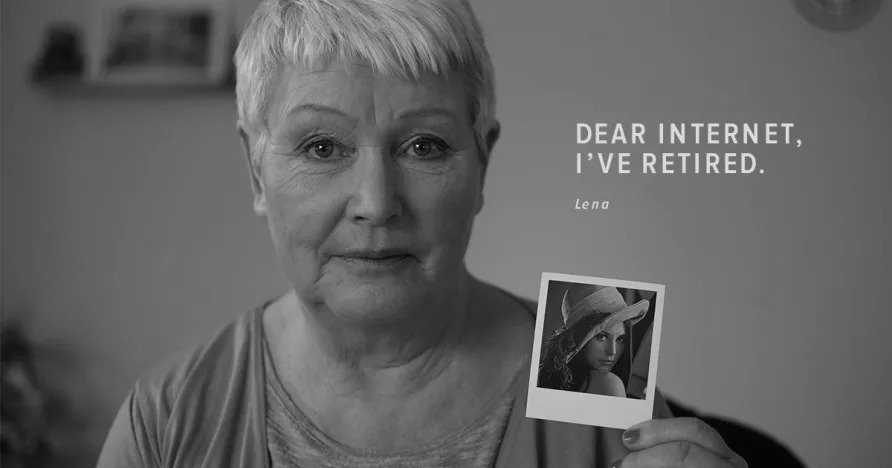

In [2]:
lena = get_lena()
lena

# Author - Clemenger BBDO (https://clemengerbbdo.com.au/en)
# Image source - https://www.losinglena.com/share.jpg
# Edits - Resized, shown in grayscale
# Licensed under Creative Commons Attribution-NonCommercial 4.0 International License 
#               (http://creativecommons.org/licenses/by-nc/4.0/)

In [3]:
lena.size

(892, 468)

In [4]:
sobel = get_sobel()
sobel

array([[ 1,  0, -1],
       [ 2,  0, -2],
       [ 1,  0, -1]])

In [5]:
show_implementation(convolve_naive)

```py
def convolve_naive(source, destination, kernel, image_width, kernel_width):
    destination_size = len(destination)
    padded_image_width = image_width + (kernel_width - 1)

    for destination_index in range(destination_size):
        acc = 0

        for kernel_idx, kernel_center in enumerate(kernel):
            kernel_y = kernel_idx // kernel_width
            kernel_x = kernel_idx % kernel_width

            destination_y = destination_index // image_width
            destination_x = destination_index % image_width
            corresponding_index_in_source = destination_y * padded_image_width + destination_x
            source_index = corresponding_index_in_source + padded_image_width * kernel_y + kernel_x

            acc += source[source_index] * kernel_center

        destination[destination_index] = min(max(acc, 0), 255)

```

That naive implementation already ain't that naive. We are assuming the image and kernel are already flat byte arrays and that a corresponding destination array has already been allocated. Furthermore, the result of a convolution is always smaller than the input, exactly by $\text{kernel width} - 1$ horizontally and similarly by $\text{kernel height} - 1$ vertically, assuming a usual odd-sized kernel. This is simply due to the kernel *overflowing* the image at the edges. Observe how, in the topmost illustration, the image is assumed to contain zeros at these nonexistent, *overflowed*, locations and the result is of the same size as the input. This is commonly referred to as same padding. In the implementation above, we assume that this size reduction is taken into consideration and the destination array is hence smaller than the source. Either the source image should be padded or the resulting image will be smaller than the original. In this example, I opted for the prior option.

With that information, the implementation is relatively straightforward. Due to the size difference between input and output, we need to translate the output, or destination, coordinates into input, or source, coordinates. That's exactly what we are doing when computing `corresponding_index_in_source`, with just a small further catch. When computing the result of a convolution for a given kernel center, the first kernel element, indexed $(0,0)$, is applied to the image pixel offset by $(- \lfloor \frac{\text{kernel width}}{2} \rfloor, - \lfloor \frac{\text{kernel height}}{2} \rfloor)$. But the coordinates of the padded source, with respect to the destination, are offset in the exact opposite manner. Hence, these nicely cancel each other out, so we don't have to consider them at all. 

####  Alright, alright, let's finally see that in action!

We just have to prepare the data as expected by the function.

In [6]:
kernel_data, kernel_height, kernel_width = sobel.flatten(), *sobel.shape
image_width, image_size = lena.size
lena_padded = pad_and_flatten_image(lena, (kernel_height//2, kernel_width//2))
destination_naive = get_destination_for_image(lena)

#### Ready when you are.

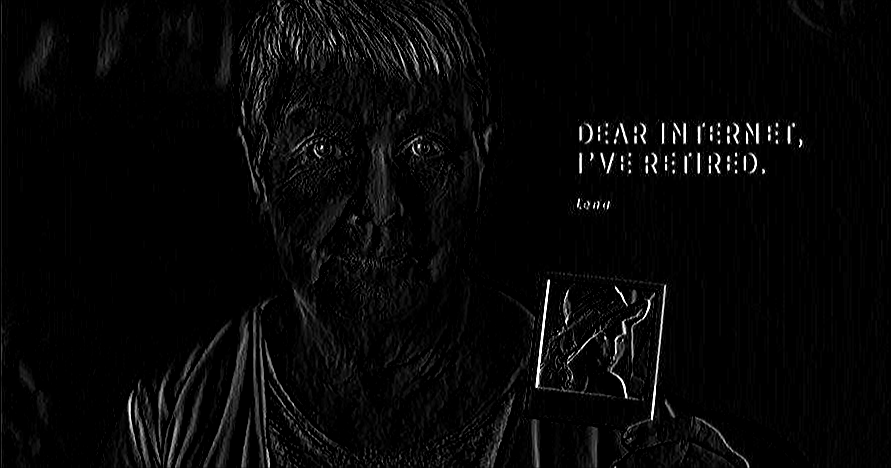

In [7]:
convolve_naive(lena_padded, destination_naive, kernel_data, image_width, kernel_width)
show_image_from_destination(destination_naive, *lena.size)

## How could we make this more efficient?

To answer this question, as always, it helps to think about what's going on when performing that convolution and where the function spends most of its time. Nowadays, pixels are usually not lacking. And for each and every one of them, we are iterating the kernel and computing the corresponding offsets. The kernel itself remains unchanged throughout. So does the size of the image. We can use these observations to our advantage and try to *hard-code* this information into the algorithm just before applying it. That's what the *on-the-fly* buzzword is all about.

To achieve this, Cogpyt provides two basic constructs, `GeneratedFunction` and `GeneratedCodeBlock`. The `cogpyt.GeneratedFunction` decorator can be used to define a function powered by on-the-fly code generation. It injects an instance of the `cogpyt.GeneratedCodeBlock` context manager. When the so defined function is executed, Cogpyt first extracts the code defined within that context manager, the generated code, and then executes it. Let's see the so optimized implementation.

In [8]:
show_implementation(convolve_cogpyt)

```py
@cogpyt.GeneratedFunction
def convolve_cogpyt(
        generated_code_block: cogpyt.GeneratedCodeBlock,
        source, destination, kernel, image_width, kernel_width
):
    destination_size = len(destination)
    padded_image_width = image_width + (kernel_width - 1)

    with generated_code_block:
        for destination_index in range(destination_size):
            acc = 0

            destination_y = destination_index // image_width
            destination_x = destination_index % image_width
            corresponding_index_in_source = destination_y * padded_image_width + destination_x
    generated_code_block.indent()

    for kernel_idx, kernel_center in enumerate(kernel):
        kernel_y = kernel_idx // kernel_width
        kernel_x = kernel_idx % kernel_width
        if kernel_center == 0:
            continue

        kernel_offset = padded_image_width * kernel_y + kernel_x

        if kernel_center == 1:
            with generated_code_block:
                acc += source[corresponding_index_in_source + kernel_offset]
        elif kernel_center == -1:
            with generated_code_block:
                acc -= source[corresponding_index_in_source + kernel_offset]
        else:
            with generated_code_block:
                acc += source[corresponding_index_in_source + kernel_offset] * kernel_center

    with generated_code_block:
        destination[destination_index] = min(max(acc, 0), 255)

```

#### Right. That sure is more lenghty, but what does it do?

For debugging purposes, you can call `get_source` on the so defined function to see the generated code. Since the whole idea of on-the-fly code generation is to generate input-specific code, that method should be called with the same arguments as the target function. Let's see how that goes.

In [9]:
destination_cogpyt = get_destination_for_image(lena)
show_implementation(convolve_cogpyt.get_source(lena_padded, destination_cogpyt, kernel_data, image_width, kernel_width))

```py
def convolve_cogpyt(source, destination, kernel, image_width, kernel_width):
    for destination_index in range(417456):
        acc = 0
        destination_y = destination_index // image_width
        destination_x = destination_index % image_width
        corresponding_index_in_source = destination_y * 894 + destination_x
        acc += source[corresponding_index_in_source + 0]
        acc -= source[corresponding_index_in_source + 2]
        acc += source[corresponding_index_in_source + 894] * 2
        acc += source[corresponding_index_in_source + 896] * -2
        acc += source[corresponding_index_in_source + 1788]
        acc -= source[corresponding_index_in_source + 1790]
        destination[destination_index] = min(max(acc, 0), 255)
```

The size of the input image is 892x468 pixels. That's exactly 417456 pixels, which has been conveniently hardcoded in the range, but that's not really the most interesting part. Notice how the kernel has also been hard-coded. All of its zero entries have been completely ignored. Instead of multiplying by $\pm 1$, we use $\pm=$. The relevant kernel entries are at the locations, (horizontally, vertically), $(0,0), (2,0), (0,1), (2,1), (0,2), (2,2)$. Since each padded image row has 892+2=894 pixels, these correspond to the offsets $0, 2, 894, 894+2=896, 2*894=1788, 2*894 + 2=1790$, which have been conveniently hard-coded as well! Last but not least, notice that the functions `convolve_naive` and `convolve_cogpyt` barely differ -- we mostly just added some `with generated_code_block:` statements where we found convenient. The generated code, the one within these contexts, also remained perfectly readable Python code.

#### Does it work? Sure.

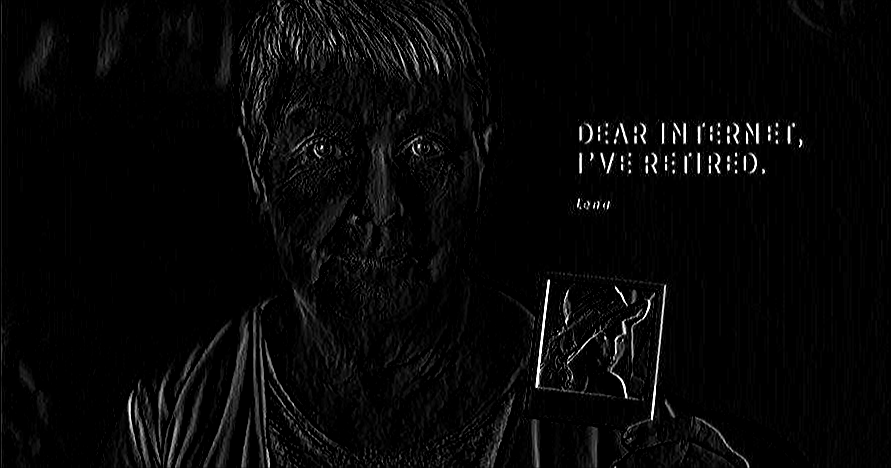

In [10]:
convolve_cogpyt(lena_padded, destination_cogpyt, kernel_data, image_width, kernel_width)
show_image_from_destination(destination_cogpyt, *lena.size)

### But what have we won?

Not much really... just yet. Python is quite infamous for its bad performance. And since it's interpreted, often some at first glance equivalent code snippets can have greatly divergent execution times. For example, see [Stackoverflow: Why is looping over range() in Python faster than using a while loop?](https://stackoverflow.com/questions/869229/why-is-looping-over-range-in-python-faster-than-using-a-while-loop).

Luckily, there are Just-In-Time (JIT) compilers for Python readily available. These can translate a subset of Python code into fast machine code prior to execution. In this example, we are going to use [Numba](https://numba.pydata.org/).

In [11]:
%%timeit -n 5
convolve_naive(lena_padded, destination_naive, kernel_data, image_width, kernel_width)

2.44 s ± 32.8 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [12]:
%%timeit -n 5
convolve_cogpyt(lena_padded, destination_cogpyt, kernel_data, image_width, kernel_width)

2.2 s ± 89.8 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


## Let's compile

To use Numba, we first have to convert some of the function arguments to the corresponding Numba types. Since `numba.jit` is a decorator, i.e. it's meant to be used as a function is defined, we have to call it with the function we want to compile. The function `get_function_from_source` retrieves a function defined by the source code generated by Cogpyt in a rather hacky way, very similar to how Cogpyt does it when executing a `GeneratedFunction`. This isn't at all elegant, but the project is, after all, just a proof of concept.

In [13]:
destination_naive_numba = NumbaList(get_destination_for_image(lena))
destination_cogpyt_numba = NumbaList(get_destination_for_image(lena))
kernel_data = NumbaList(kernel_data)

convolve_naive_numba = jit(nopython=True)(convolve_naive)

convolve_cogpyt_function = get_function_from_source(
    convolve_cogpyt.get_source(lena_padded, destination_cogpyt, kernel_data, image_width, kernel_width),
    convolve_cogpyt.name
)
convolve_cogpyt_numba = jit(nopython=True)(convolve_cogpyt_function)

In [14]:
%%timeit -n 50
convolve_naive_numba(lena_padded, destination_naive_numba, kernel_data, image_width, kernel_width)

43.6 ms ± 1.98 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [15]:
%%timeit -n 50
convolve_cogpyt_numba(lena_padded, destination_cogpyt_numba, kernel_data, image_width, kernel_width)

6.1 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


### Now we're talking!

Of course, the main speedup comes from Numba. Still, the implementation using on-the-fly code generation is about 7 times more efficient. If the function is meant to be used in a real-time application, in conjuction with other functionality, as is not unheard of in the computer vision field, this speedup might turn out to be crucial for the feasibility of a project.

#### ...and it even works! :)

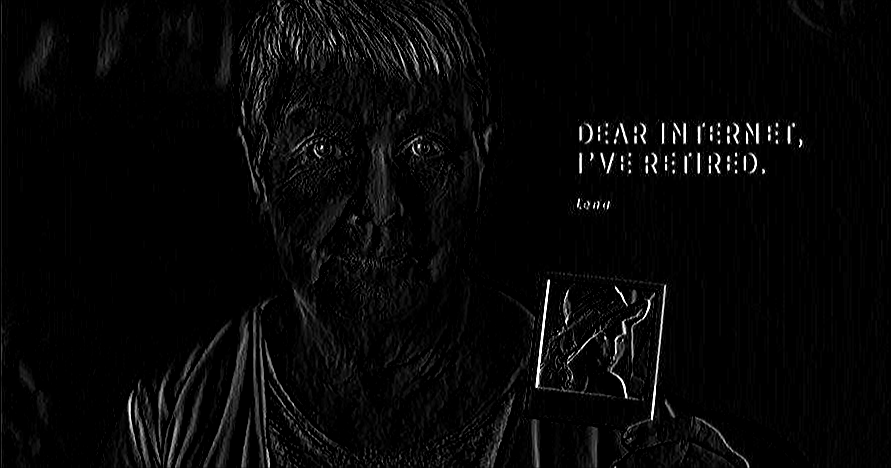

In [16]:
show_image_from_destination(destination_cogpyt_numba, *lena.size)

## A short disclaimer

The given execution times above are just for the convolution operation. The code generation and just-in-time compilation both introduce a significant overhead. A further overhead might need to be considered if the image and kernel are stored in a different format and the destination array has to be allocated. I believe the achieved results are nevertheless significant, as there are numerous situations in which same sized images, from the same source (e.g. video stream) are processed with the same kernel and stored in the same destination array, perhaps with some multiple buffering added for good measure. In such situations, any overhead quickly becomes negligible. I am, of course, not the first to implement this approach. The sole contribution of this project is perhaps making on-the-fly code generation a little more accessible.


#### On on-the-fly code generation and JIT compilation

Cogpyt is a proof of concept, it sure isn't particularly fast!

In [17]:
%%timeit -n 50
get_function_from_source(
    convolve_cogpyt.get_source(lena_padded, destination_cogpyt_numba, kernel_data, image_width, kernel_width),
    convolve_cogpyt.name
)

4.95 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


And numba has a lot of heavy lifting to do...

In [18]:
# By giving an empty destination array,
# the function won't do anything
# but we can measure numba's compilation time;
# We need the list to be typed though, hence the pop hack
# to create an int64 empty list
no_destination = NumbaList([0])
no_destination.pop()

def jit_compile():
    no_convolution = get_function_from_source(
        convolve_cogpyt.get_source(lena_padded, no_destination, kernel_data, image_width, kernel_width),
        convolve_cogpyt.name
    )
    no_convolution_numba = jit(nopython=True)(no_convolution)
    no_convolution_numba(lena_padded, no_destination, kernel_data, image_width, kernel_width)
    
jit_compile()

In [19]:
%%timeit -n 10
jit_compile()

118 ms ± 4.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### And on (in)efficient data structures...

If the input image and kernel are stored in different formats and the destination array also needs to be allocated, then the execution time increases significantly.

In [20]:
def end_to_end_convolution(image, np_kernel):
    # flatten data and calculate dimensions
    kernel_data, kernel_height, kernel_width = np_kernel.flatten(), *np_kernel.shape
    image_padded = pad_and_flatten_image(image, (kernel_height//2, kernel_width//2))
    image_width, image_height = image.size

    # prepare data and destination in numba format
    source = NumbaList(image_padded)
    destination = NumbaList(get_destination_for_image(lena))
    kernel = NumbaList(kernel_data)
    
    convolve_cogpyt_numba(source, destination, kernel, image_width, kernel_width)
    return get_image_from_destination(destination, image_width, image_height)

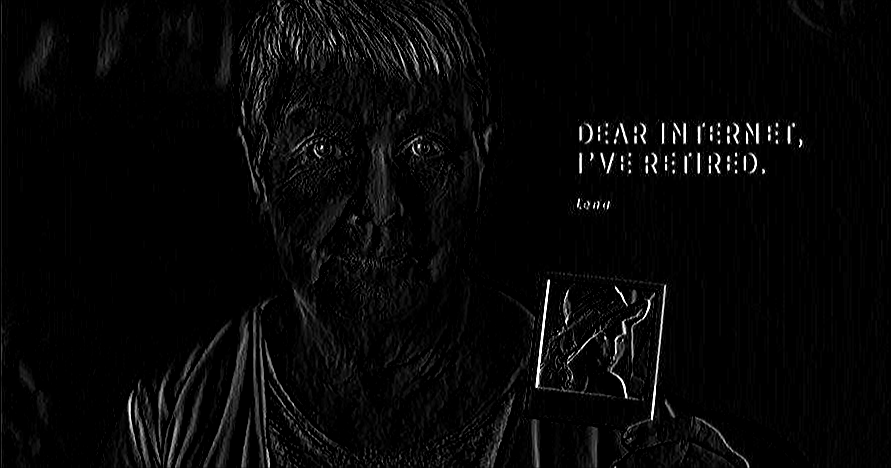

In [21]:
end_to_end_convolution(lena, sobel)

In [22]:
%%timeit
end_to_end_convolution(lena, sobel)

1.83 s ± 23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
